### Setup

In [25]:
import sys
sys.path.append('../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [26]:
from darts.models import TSMixerModel

In [27]:
import wandb
wandb.login()

True

### Configuration

In [28]:
TEST_YEAR = 2019

In [29]:
RANDOM_STATE = 0

In [30]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    },
    random_state=RANDOM_STATE
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best model

In [31]:
params = get_best_parameters('tsmixer-simple-validation', 'tsmixer')

WIS of best run: 208.3974396865889


In [32]:
params

{'model': 'tsmixer',
 'dropout': 0,
 'ff_size': 128,
 'n_epochs': 1000,
 'norm_type': 'TimeBatchNorm2d',
 'optimizer': 'AdamW',
 'test_year': 2019,
 'activation': 'GELU',
 'batch_size': 32,
 'num_blocks': 8,
 'hidden_size': 32,
 'use_encoders': True,
 'use_features': False,
 'use_covariates': True,
 'normalize_before': False,
 'optimizer_kwargs': {'lr': 0.0005, 'weight_decay': 0.001},
 'input_chunk_length': 8,
 'use_static_covariates': False}

In [33]:
# params['use_encoders'] = False

In [34]:
name = params.pop('model')
test_year = params.pop('test_year')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
optimizer = params.pop('optimizer')

params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

if not use_covariates:
    del params['lags_past_covariates']

In [35]:
model = TSMixerModel(
    **params,
    add_encoders=ENCODERS if use_encoders else None,
    **SHARED_ARGS
)

In [43]:
model.model_params['random_state'] = 1

In [44]:
model

TSMixerModel(output_chunk_shift=0, hidden_size=32, ff_size=128, num_blocks=8, activation=GELU, dropout=0, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=False, n_epochs=1000, batch_size=32, optimizer_kwargs={'lr': 0.0005, 'weight_decay': 0.001}, input_chunk_length=8, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, output_chunk_length=4, likelihood=NegativeBinomialLikelihood(), pl_trainer_kwargs={'enable_progress_bar': True, 'enable_model_summary': False, 'accelerator': 'cpu', 'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7f7042e54460>]}, random_state=1)

# Load data

In [12]:
targets_train, targets_validation, covariates = get_test_data(TEST_YEAR)

<Axes: xlabel='date'>

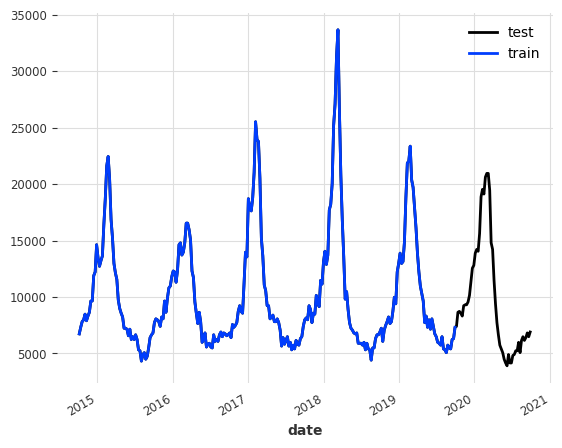

In [13]:
targets_validation['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

In [14]:
multiple_series = False

In [15]:
if multiple_series:
    train = [targets_train[col] for col in targets_train.columns]
    validation = [targets_validation[col] for col in targets_validation.columns]
else:
    train = targets_train
    validation = targets_validation

if use_features:
    ts_features = load_features(lag=8)
    cov = covariates.slice_intersect(ts_features) # features start a bit later because of rolling window
    ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    if multiple_series:
        ts_features = [ts_features[[col for col in ts_features.columns if target in col]] for target in TARGETS] # has to be in the same order as the target series!
        cov = [concatenate([cov.with_static_covariates(None), features_age], axis='component') for features_age in ts_features]
    else:
        cov = concatenate([cov.with_static_covariates(None), ts_features], axis='component')
else:
    if multiple_series:
        cov = [covariates]*len(train)
    else:
        cov = covariates

# Train model

In [16]:
HFC_PATH = f'../data/pre-covid/{name}0-{test_year}.csv'
MODEL_PATH = f'../models/pre-covid/{name}0-{test_year}.pt'

In [17]:
MODEL_PATH

'../models/pre-covid/tsmixer0-2019.pt'

In [18]:
model.fit(targets_train, past_covariates=covariates if use_covariates else None)

Epoch 999/999 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 0:00:00 • 0:00:00 23.64it/s train_loss: 6.764

`Trainer.fit` stopped: `max_epochs=1000` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=32, ff_size=128, num_blocks=8, activation=GELU, dropout=0, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=False, n_epochs=1000, batch_size=32, optimizer_kwargs={'lr': 0.0005, 'weight_decay': 0.001}, input_chunk_length=8, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, output_chunk_length=4, likelihood=NegativeBinomialLikelihood(), pl_trainer_kwargs={'enable_progress_bar': True, 'enable_model_summary': False, 'accelerator': 'cpu', 'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7f7043022460>]}, random_state=0)

In [23]:
model.save(MODEL_PATH)

In [24]:
# TSMixerModel.load(MODEL_PATH)

# Compute historical forecasts

In [19]:
if multiple_series:
    validation_start = targets_train[0].end_time() + targets_train[0].freq
else:
    validation_start = targets_train.end_time() + targets_train.freq

In [20]:
hfc = model.historical_forecasts(
    series=targets_validation,
    past_covariates=covariates if use_covariates else None,
    start=validation_start,
    forecast_horizon=HORIZON,
    stride=1,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=NUM_SAMPLES,
    enable_optimization=True
)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:11 • 0:00:00 0.20it/s

In [21]:
df = reshape_hfc(hfc)

In [28]:
df.to_csv(HFC_PATH, index=False)
print(HFC_PATH)

../data/pre-covid/tsmixer0-2019.csv


In [29]:
# df = pd.read_csv(HFC_PATH)

# Plot historical forecasts

In [23]:
if multiple_series:
    df_plot = prepare_plot_data(df, concatenate(targets_validation, axis='component')[test_start : ])
else:
    df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

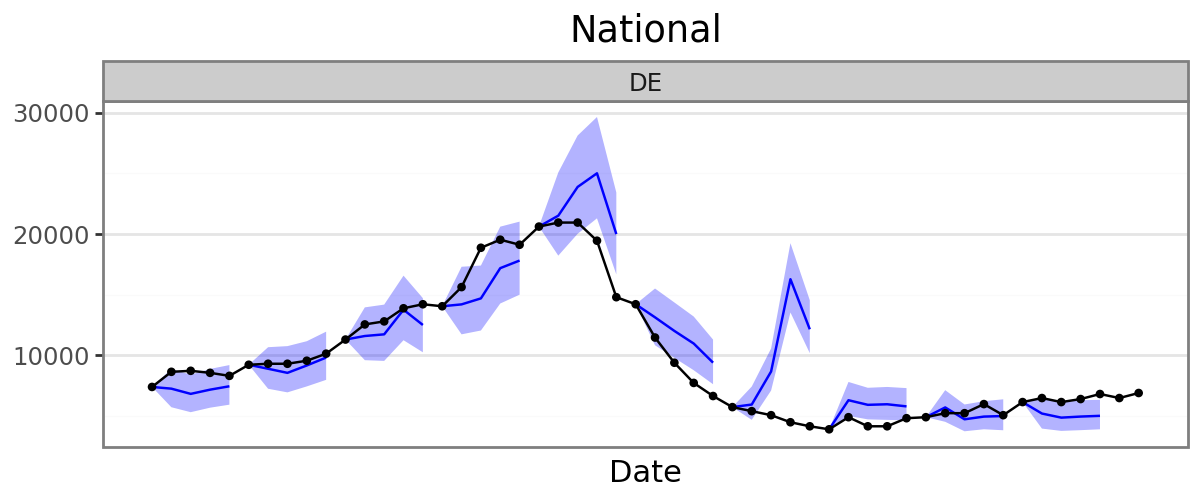

In [35]:
plot_forecasts(df_plot, 'national', start=1)

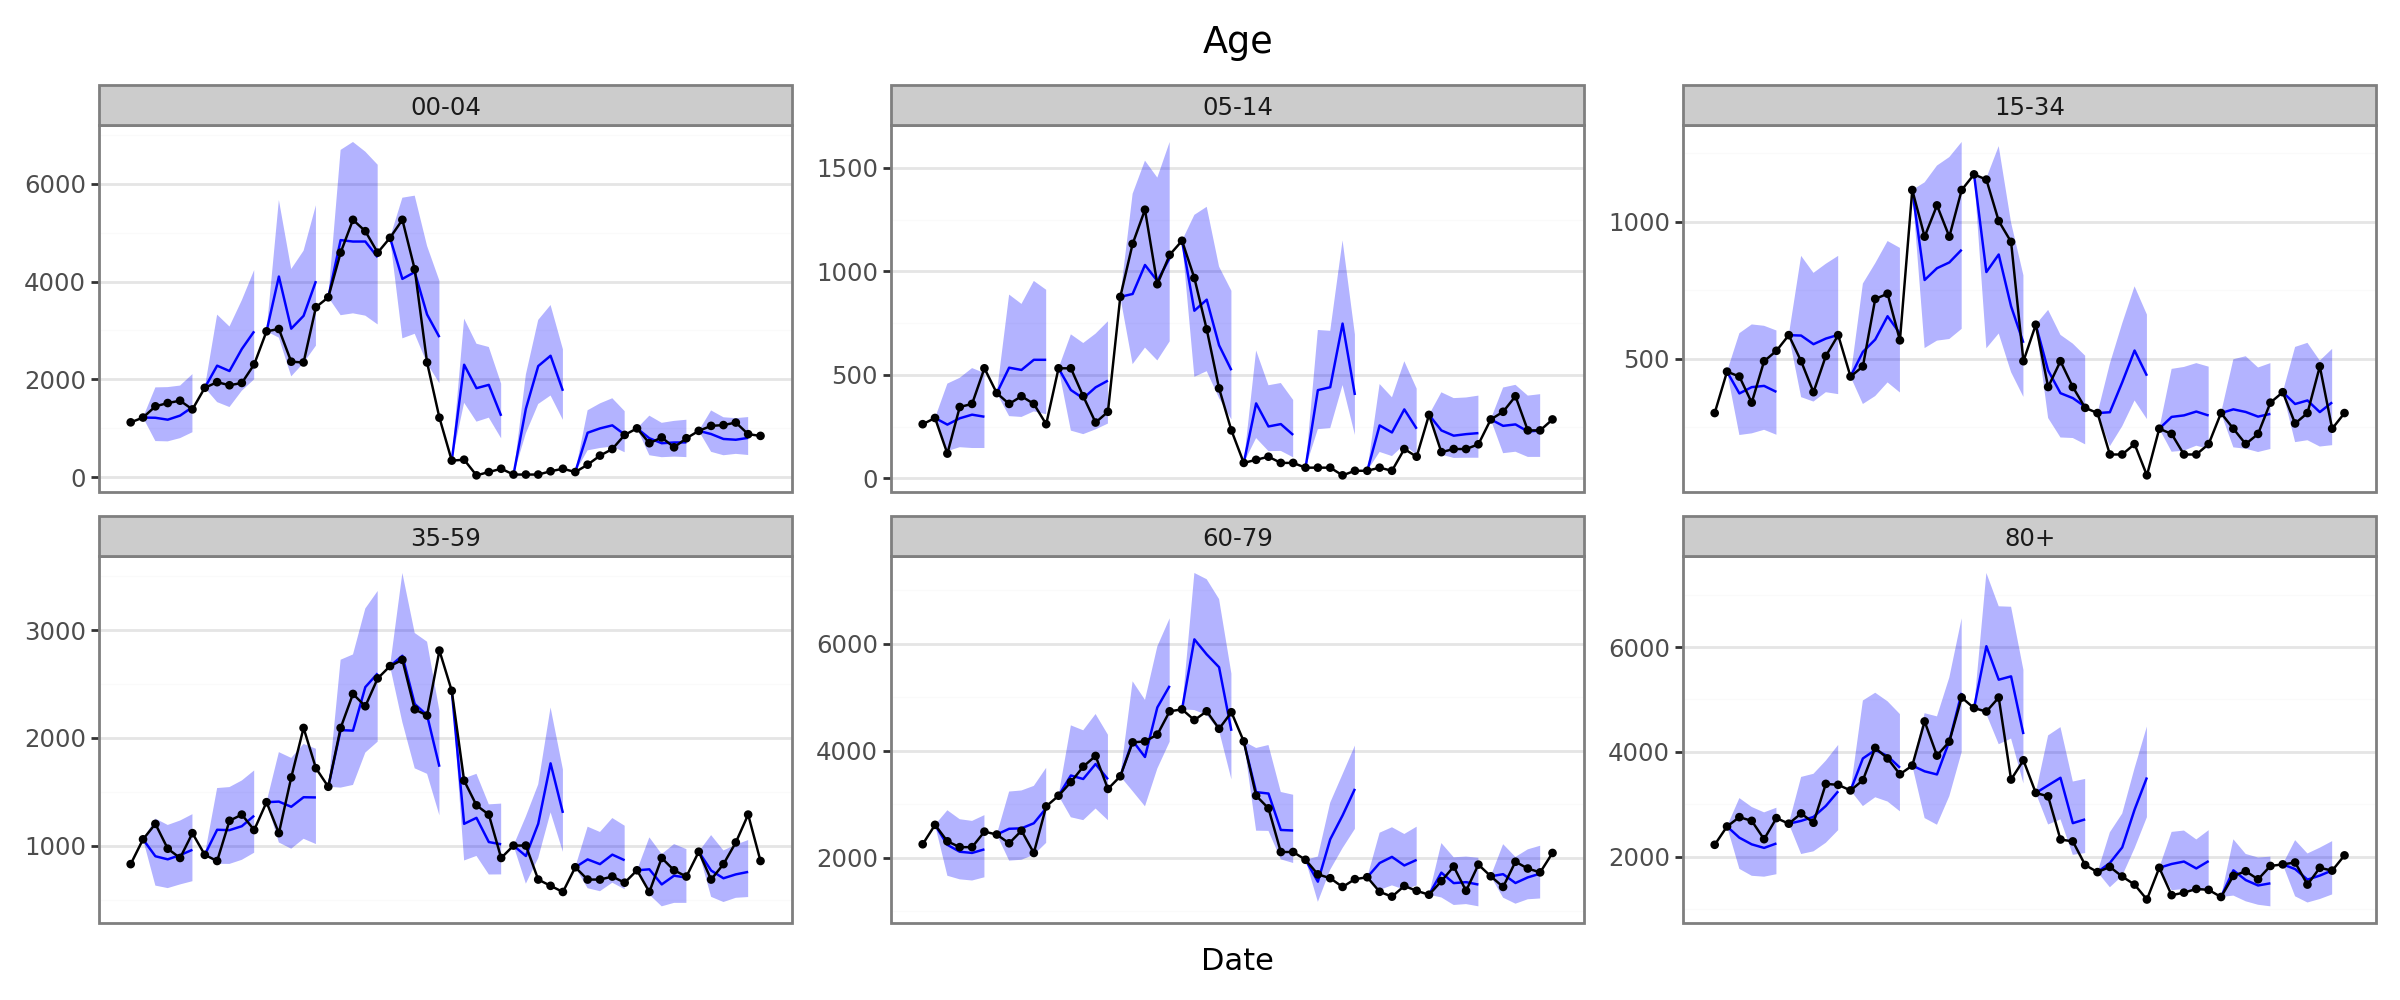

In [32]:
plot_forecasts(df_plot, 'age', start=2)

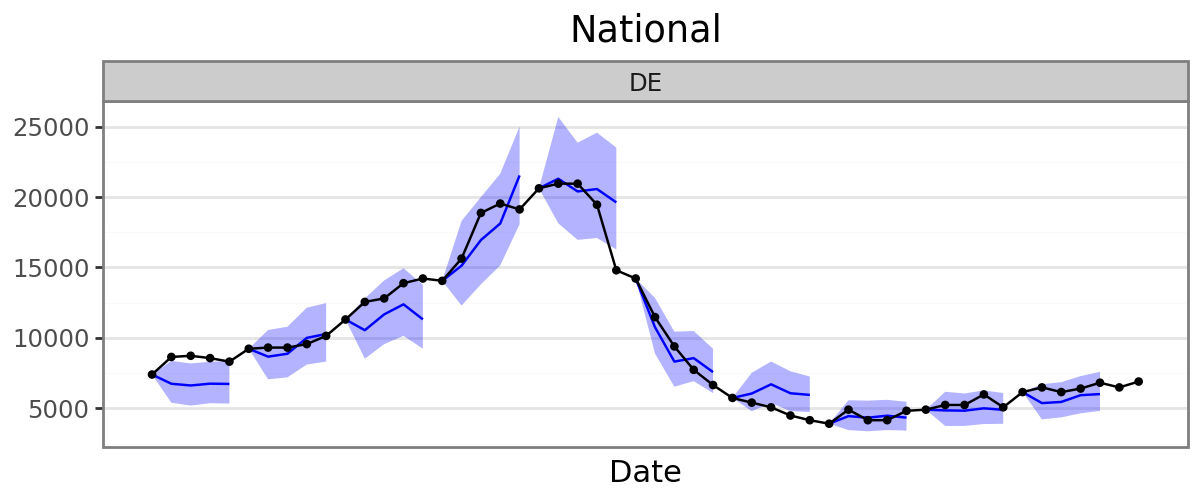

In [28]:
plot_forecasts(df_plot, 'national', start=1)

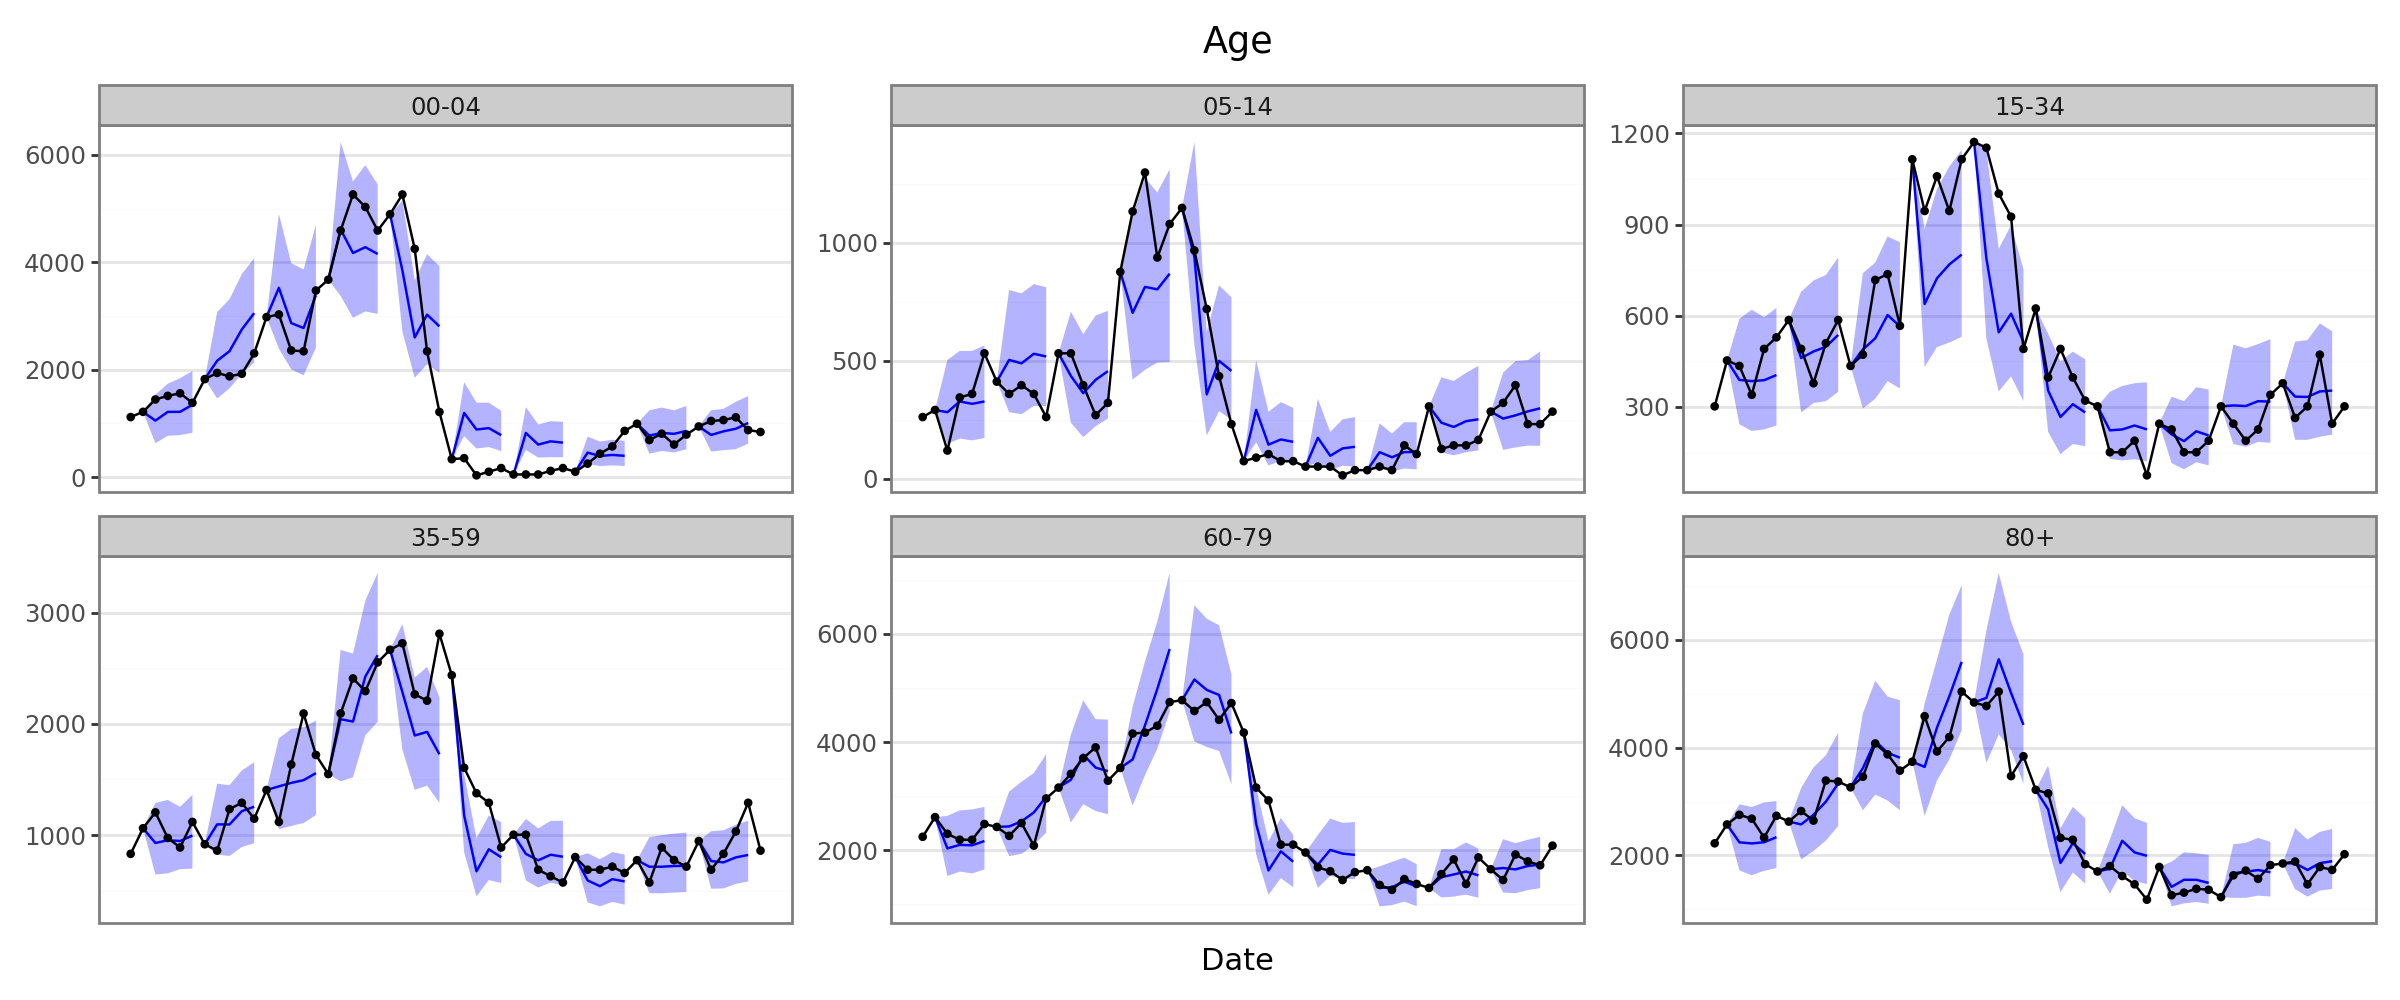

In [30]:
plot_forecasts(df_plot, 'age', start=2)

### no encoders

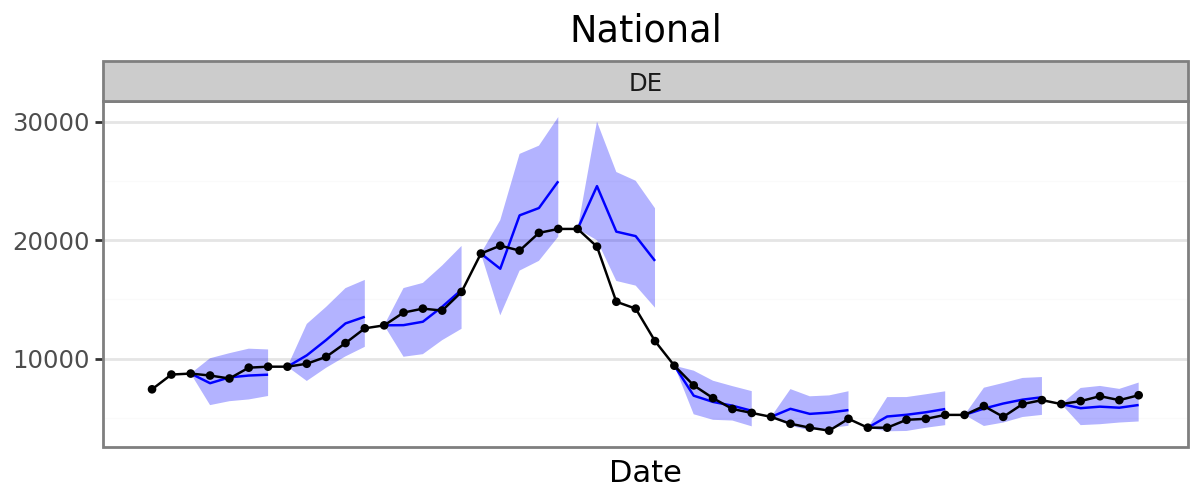

In [54]:
plot_forecasts(df_plot, 'national', start=3)

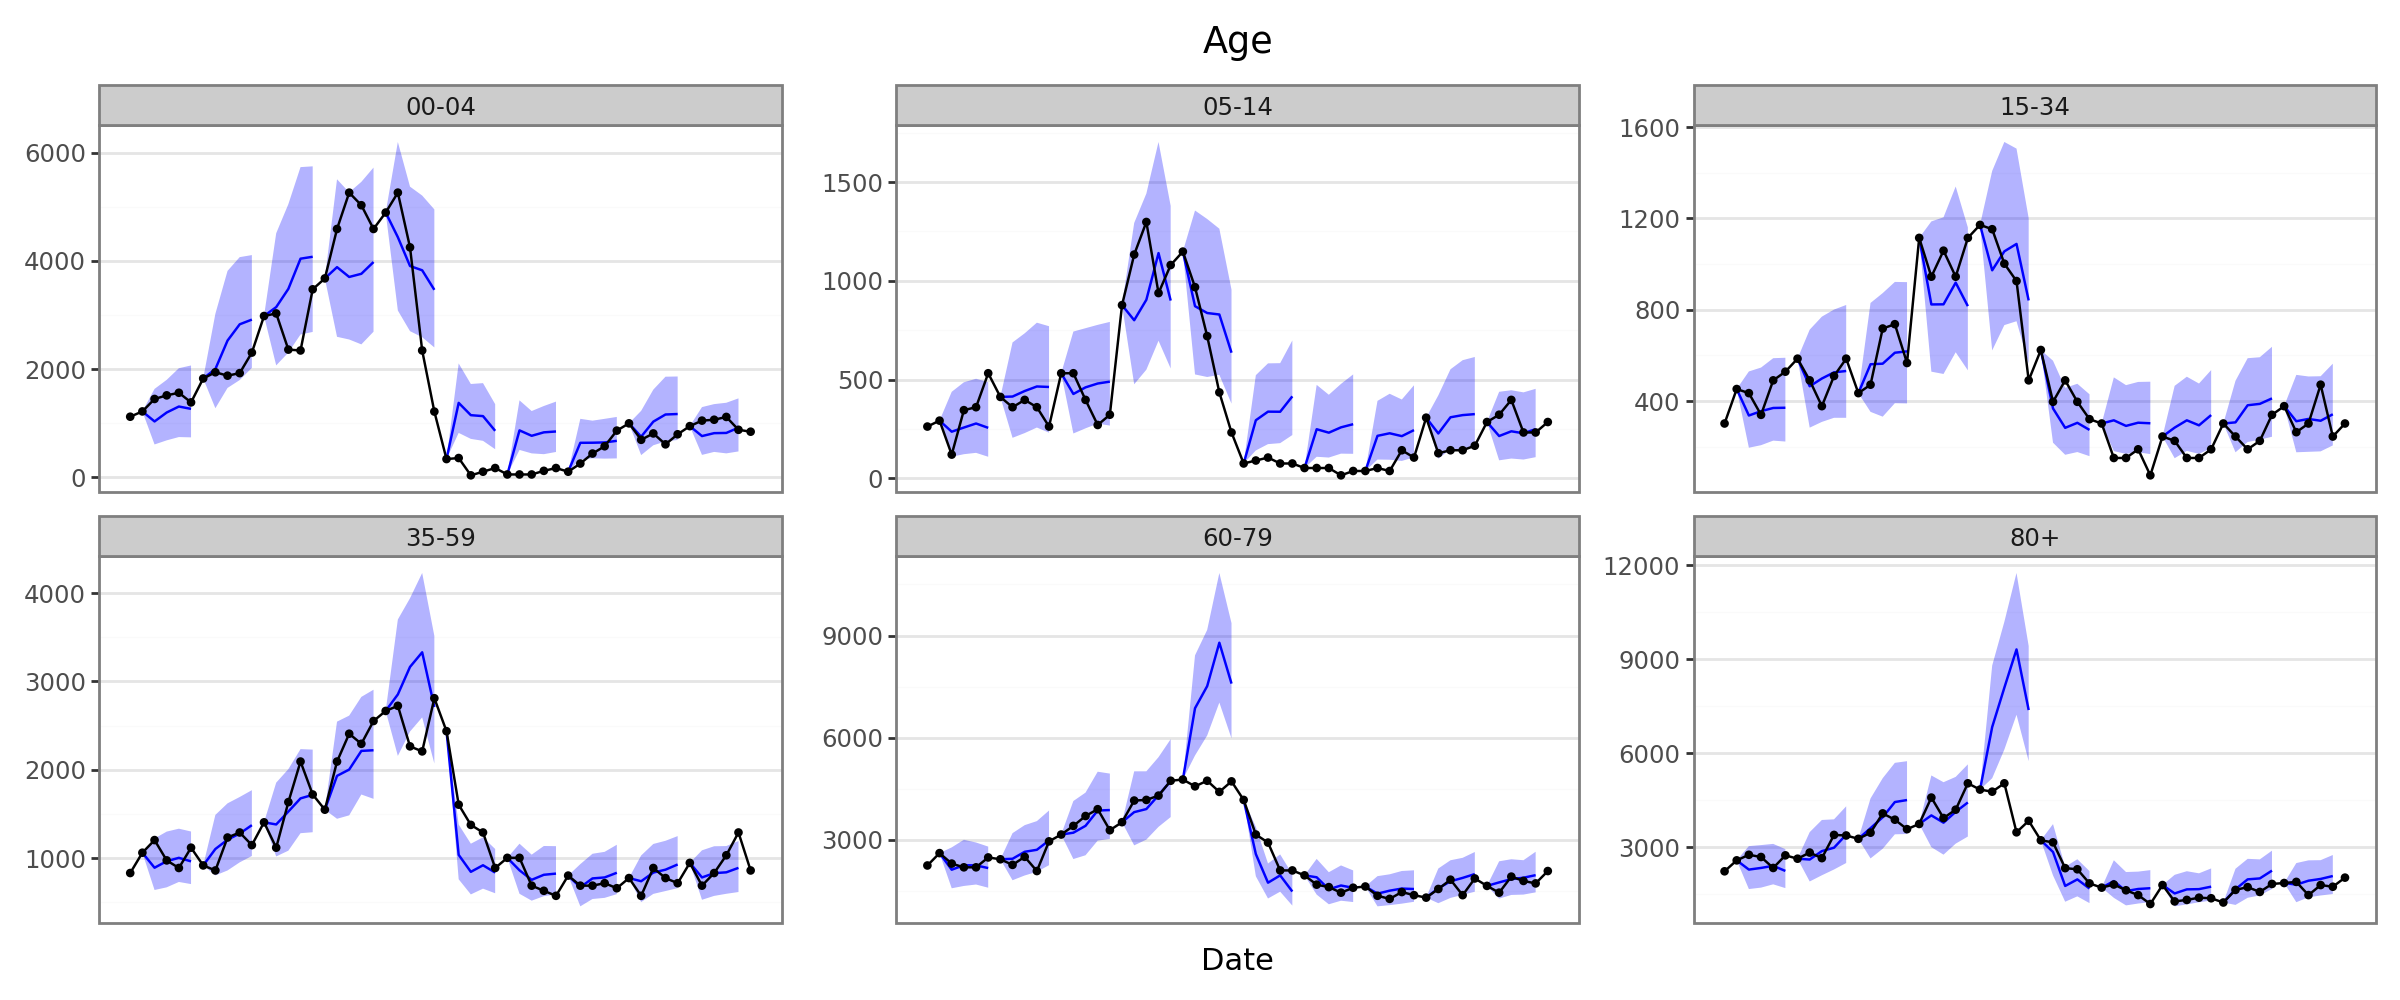

In [56]:
plot_forecasts(df_plot, 'age', start=2)

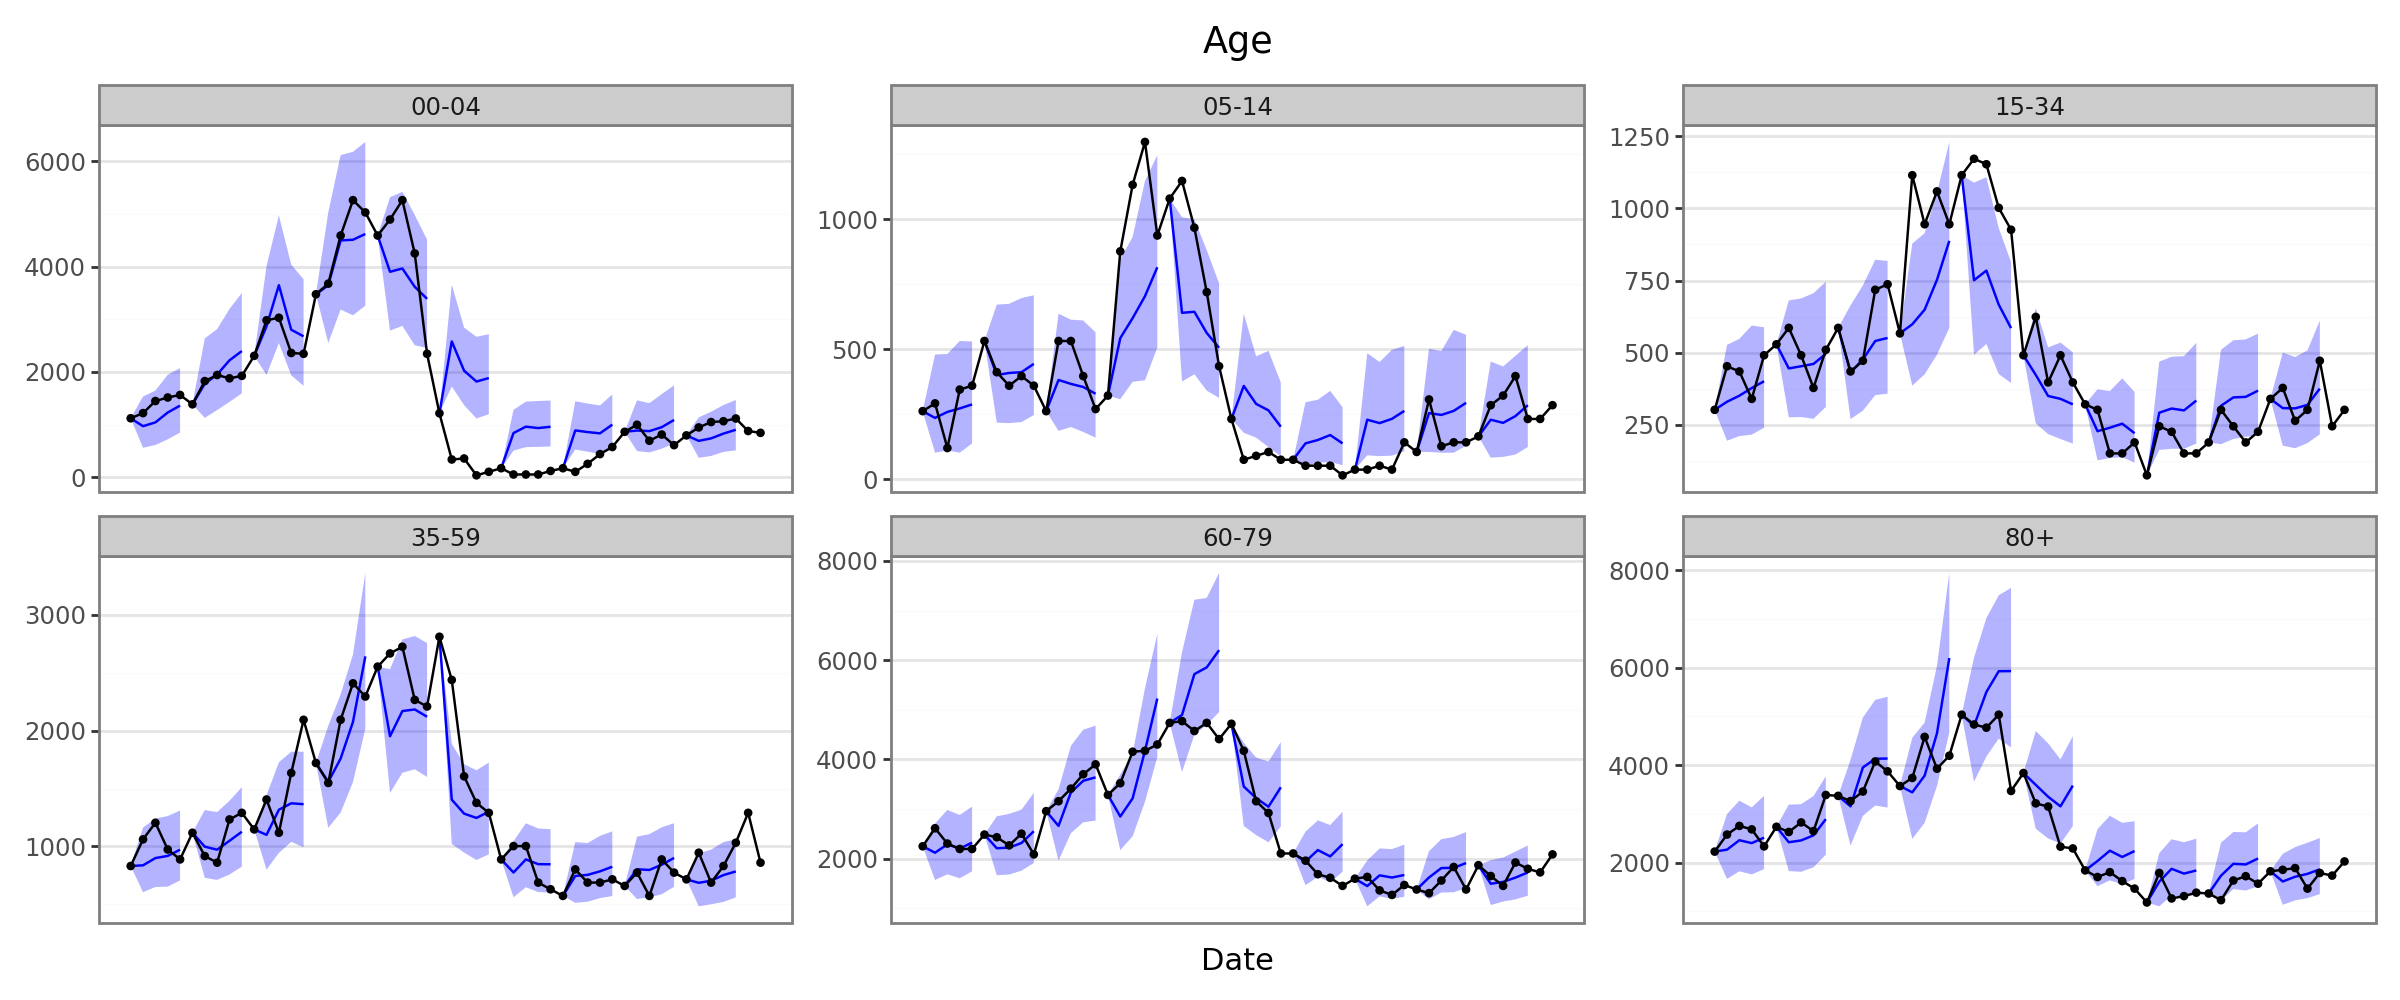

In [ ]:
plot_forecasts(df_plot, 'age', start=1)